# Homework 5: Binary classification


In this assignment, you need to apply supervised learning models to a breast cancer dataset. The goal is to make binary prediction for a sample to be malignant or benign. You should use logistic regression, decision tree, random forest and support vector machine to make the prediction. Then select one model to do hyperparameter optimization.

Data Attribute Information:

 - 1) ID number 
 - 2) Diagnosis (M = malignant, B = benign) 
 
 - 3-32) Ten real-valued features are computed for each cell nucleus:

 - a) radius (mean of distances from center to points on the perimeter) 
 - b) texture (standard deviation of gray-scale values) 
 - c) perimeter 
 - d) area 
 - e) smoothness (local variation in radius lengths) 
 - f) compactness (perimeter^2 / area - 1.0) 
 - g). concavity (severity of concave portions of the contour) 
 - h). concave points (number of concave portions of the contour) 
 - i). symmetry 
 - j). fractal dimension ("coastline approximation" - 1)

The mean, standard error (SE) and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

## Load Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# keeps the plots in one place. calls image as static pngs
%matplotlib inline 
import matplotlib.pyplot as plt # side-stepping mpl backend
import matplotlib.gridspec as gridspec # subplots
import mpld3 as mpl

#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

## Load the data

In [3]:
df = pd.read_csv("hw5_data.csv",header = 0)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Clean and prepare data

#### 1(a)
rubric={points:1}

1. Remove the 'id' column

2. Remove the last column 'Unnamed: 32'

1(a) solution

In [5]:
df = df.drop(['id', 'Unnamed: 32'], axis = 1)

#### 1(b)
rubric={points:1}

What are the unique classes in the target column 'diagnosis'?

1(b) solution

In [7]:
df['diagnosis'].unique()

array(['M', 'B'], dtype=object)

Change the 'M' label to 1 and 'B' label to 0

In [8]:
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## EDA

#### 1(c)
rubric={points:1}

Summarize the dataset

1(c) solution

In [9]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

#### 1(d)
rubric={points:1}

Make a histogram to show the number of cases in the 'diagnosis' column

1(d) solution

<function matplotlib.pyplot.show(close=None, block=None)>

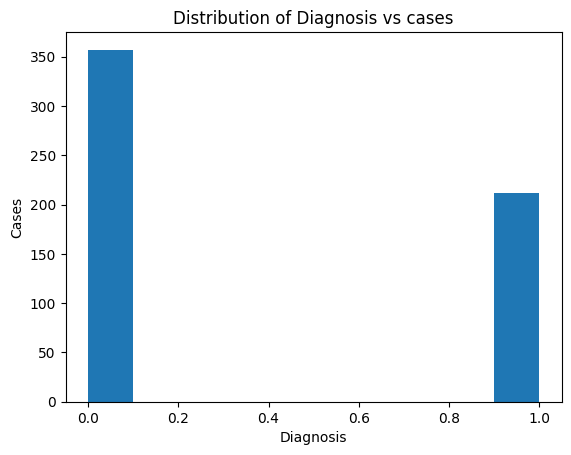

In [12]:
plt.hist(df['diagnosis'])
plt.xlabel('Diagnosis')
plt.ylabel('Cases')
plt.title('Distribution of Diagnosis vs cases')
plt.show

### nucleus features vs diagnosis

Only consider the first 10 features, i.e., _mean, then divide the dataframe into two based on diagnosis 

In [13]:
features_mean=list(df.columns[1:11])
# split dataframe into two based on diagnosis
dfM=df[df['diagnosis'] ==1]
dfB=df[df['diagnosis'] ==0]

#### 1(e)
rubric={points:4}

Make a stacked histogram of two diagnoses (1 and 0) for each of these 10 features. So 10 stacked histograms will be generated. The x axis is the binned values of the feature; the y axis is the fraction of the occurrence for each bin value. The title is the feature.

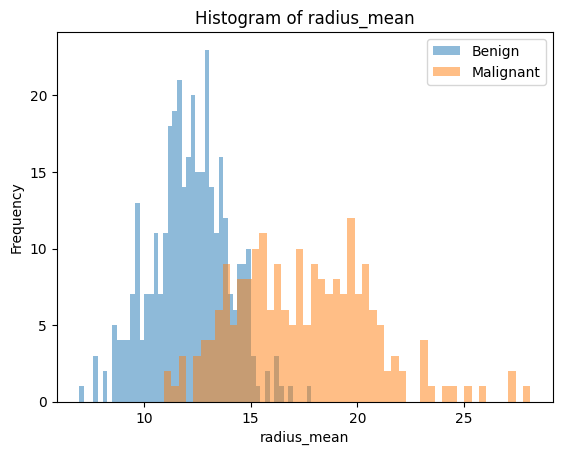

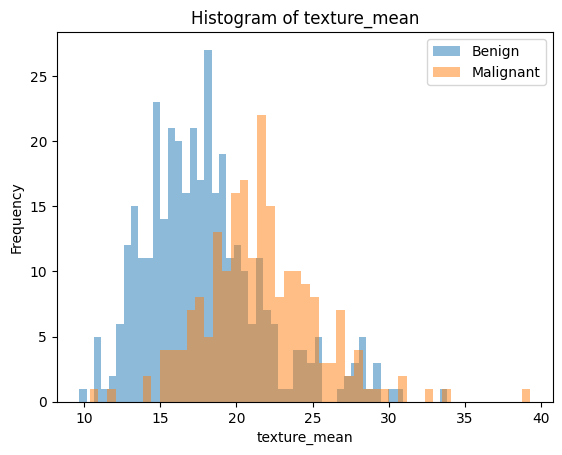

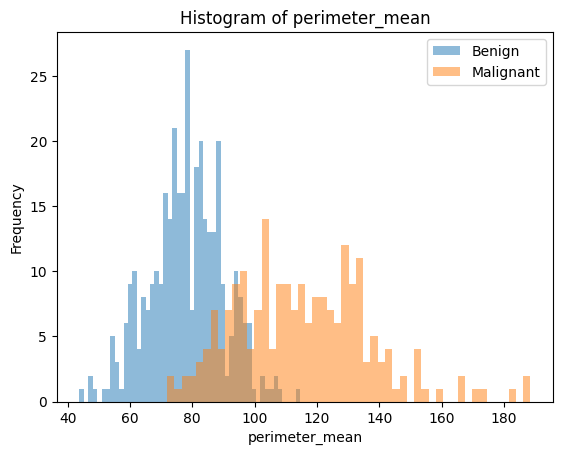

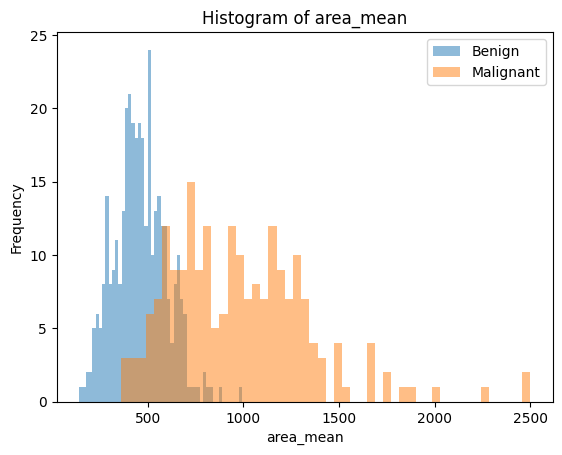

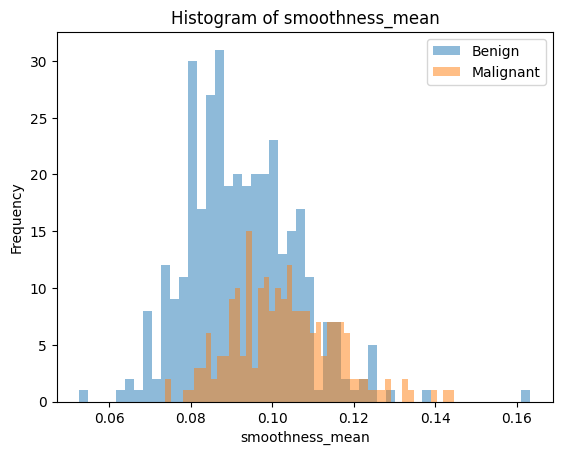

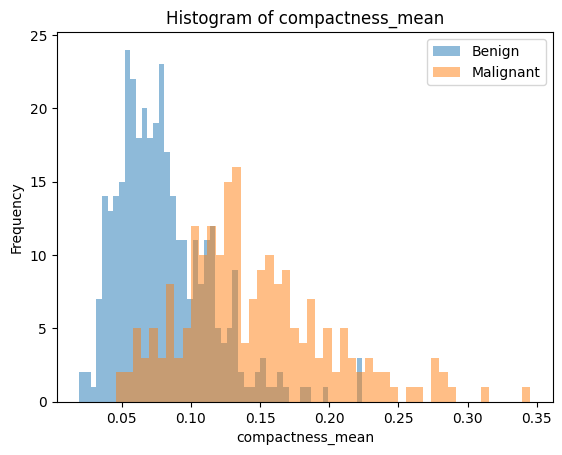

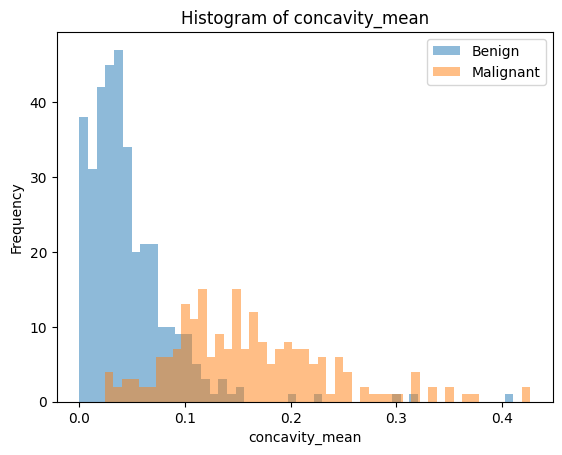

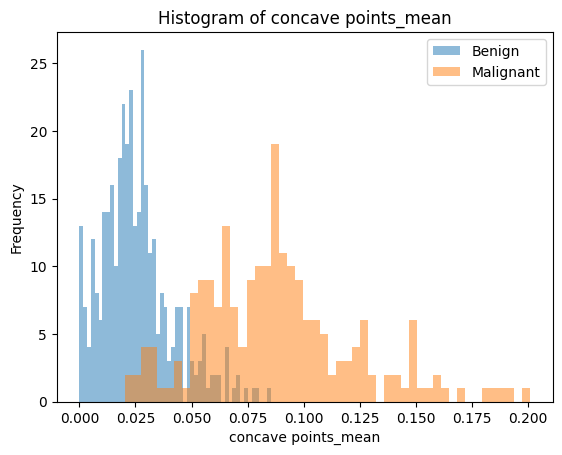

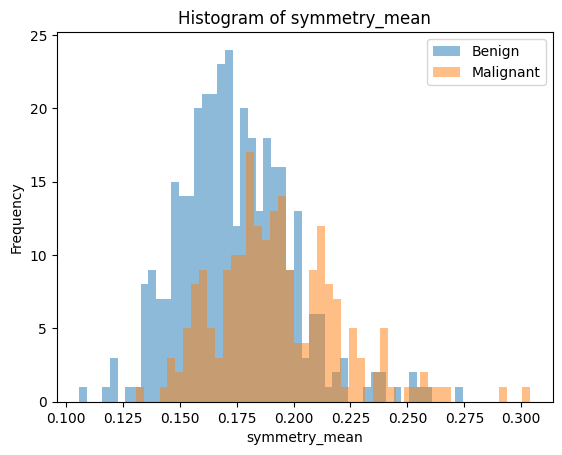

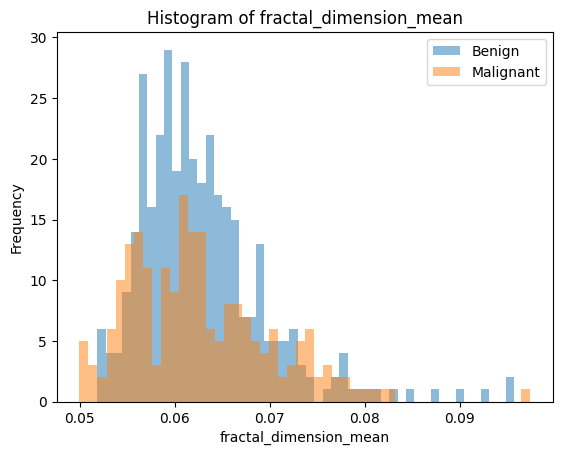

In [24]:
for x in features_mean:
    ax = df.groupby('diagnosis')[x].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(x)
    plt.title('Histogram of ' + x)
    plt.legend(['Benign', 'Malignant'])
    plt.show()

#### 1(f)
rubric={points:2}

What are your observations? Which features are more informative in predicting the cancer diagnosis? Which features are less informative?

Radius, perimeter, area, compactness, concavity, and concave points would be more informative, while texture, smoothness, symmetry, and fractal_dimension are less informative.


## Creating a test set and a training set


#### 1(g)
rubric={points:1}

Make a simple 70:30 split to create a training data set and a test data set.

1(g) solution

In [17]:
train_df, test_df = train_test_split(df, test_size=.3)

In [21]:
X_train, y_train = train_df.drop(columns=['diagnosis']), train_df['diagnosis']
X_test, y_test = test_df.drop(columns=['diagnosis']), test_df['diagnosis']

## Model Classification

Here we are going to build a classification model and evaluate its performance using the training set.



In [22]:
#Generic function for making a classification model and accessing the performance. 
# From AnalyticsVidhya tutorial
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(n_splits=5)
  error = []
  for train, test in kf.split(data):
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

### Logistic Regression model

Logistic regression is widely used for classification of discrete data. In this case we will use it for binary (1,0) classification.

Based on the observations in the histogram plots, we can reasonably hypothesize that the cancer diagnosis depends on the (1)mean cell radius, (2) mean perimeter, (3) mean area, (4) mean compactness, (5) mean concavity and (6) mean concave points. We can then  perform a logistic regression analysis using those features as follows:

#### 1(h)
rubric={points:3}

Build a logistic regression model using the 6 features shonw above

Hint: use the _Classification_model_ function above

1(h) solution

In [33]:
lr_model = LogisticRegression()
predictors = ['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']
outcome = 'diagnosis'
classification_model(lr_model, train_df, predictors, outcome)

Accuracy : 89.950%
Cross-Validation Score : 87.500%
Cross-Validation Score : 90.000%
Cross-Validation Score : 90.417%
Cross-Validation Score : 89.964%
Cross-Validation Score : 89.440%


c:\Users\Connor Lynch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Connor Lynch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

#### 1(i)
rubric={points:1}

The prediction accuracy is reasonable. What happens if we use just one predictor? Use the mean_radius:

1(i) solution

In [34]:
classification_model(lr_model, train_df, ['radius_mean'], outcome)

Accuracy : 89.447%
Cross-Validation Score : 87.500%
Cross-Validation Score : 90.000%
Cross-Validation Score : 91.250%
Cross-Validation Score : 89.956%
Cross-Validation Score : 88.674%


This gives a similar prediction accuracy and a cross-validation score.


The accuracy of the predictions are good but not great. The cross-validation scores are reasonable. 
Can we do better with another model?

### Decision Tree Model

#### 1(j)
rubric={points:3}

Build a decision tree model with the same 6 features

1(j) solution

In [35]:
dt_model = DecisionTreeClassifier()
classification_model(dt_model, train_df, predictors, outcome)

Accuracy : 100.000%
Cross-Validation Score : 92.500%
Cross-Validation Score : 90.625%
Cross-Validation Score : 90.833%
Cross-Validation Score : 91.543%
Cross-Validation Score : 91.462%


#### 1(k)
rubric={points:1}

Are we over-fitting the model? 

Let's build the decision tree model with a single predictor, the mean radius of the cell. What is your observation?

1(k) solution

In [36]:
classification_model(dt_model, train_df, ['radius_mean'], outcome)

Accuracy : 97.236%
Cross-Validation Score : 85.000%
Cross-Validation Score : 85.625%
Cross-Validation Score : 85.417%
Cross-Validation Score : 85.265%
Cross-Validation Score : 85.174%


The accuracy of the prediction is much much better here.  But does it depend on the predictor?

Using a single predictor gives a 97% prediction accuracy for this model but the cross-validation score is not that great. 

### Randome Forest

#### 1(l)
rubric={points:3}

Build a random forest model with the same 6 features

Use n_estimator = 100, min_samples_split=25, max_depth=7, max_features=2

1(l) solution

In [40]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=25, max_depth=7, max_features=2)
classification_model(rf_model, train_df, predictors, outcome)

Accuracy : 94.472%
Cross-Validation Score : 88.750%
Cross-Validation Score : 91.250%
Cross-Validation Score : 91.667%
Cross-Validation Score : 92.168%
Cross-Validation Score : 91.709%


 An advantage with Random Forest is that it returns a feature importance matrix which can be used to select features. So lets select the top 5 features and use them as predictors.

#### 1(m)
rubric={points:1}

Create a series with feature importance, sort it and print this series

1(m) solution

In [42]:
importances = rf_model.feature_importances_
pd.Series(importances, index=predictors).sort_values(ascending=False)

concave points_mean    0.259100
perimeter_mean         0.225428
area_mean              0.192587
radius_mean            0.155335
concavity_mean         0.144631
compactness_mean       0.022919
dtype: float64

1(n)
rubric={points:1}

What happens if we use a single predictor as before? Just check.

1(n) Solution

In [43]:
classification_model(rf_model, train_df, ['radius_mean'], outcome)

Accuracy : 90.201%
Cross-Validation Score : 87.500%
Cross-Validation Score : 90.625%
Cross-Validation Score : 89.583%
Cross-Validation Score : 88.390%
Cross-Validation Score : 87.927%


This gives a better prediction accuracy too but the cross-validation is not great.


1(o)

rubric={points:3}

Create a SVM model with the same 6 features

1(o) solution:

In [44]:
from sklearn.svm import SVC
SVM_model = SVC()
classification_model(SVM_model, train_df, predictors, outcome)

Accuracy : 89.950%
Cross-Validation Score : 87.500%
Cross-Validation Score : 90.625%
Cross-Validation Score : 90.833%
Cross-Validation Score : 90.277%
Cross-Validation Score : 89.690%


1(p)

rubric={points:3}

Select one model to optimize hyperparameters

1(p) solution:

In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

random_search = RandomizedSearchCV(
    SVM_model, param_distributions=param_grid, n_jobs=-1, n_iter=50, cv=5, random_state=123
)
random_search.fit(X_train, y_train)


c:\Users\Connor Lynch\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                                        'gamma': [0.001, 0.01, 0.1, 1.0, 10,
                                                  100]},
                   random_state=123)

In [50]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_gamma",
        "param_C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,35,35
mean_test_score,0.922057,0.917057,0.914525,0.658291,0.658291,0.658291,0.658291,0.658291,0.658291,0.658291,...,0.658291,0.658291,0.658291,0.658291,0.658291,0.658291,0.658291,0.658291,0.655759,0.655759
param_gamma,0.001000,0.001000,0.001000,0.001000,1.000000,0.100000,100.000000,10.000000,1.000000,0.100000,...,0.100000,1.000000,10.000000,100.000000,0.001000,0.010000,0.100000,100.000000,0.010000,0.010000
param_C,1.000000,100.000000,10.000000,0.001000,100.000000,100.000000,10.000000,10.000000,10.000000,10.000000,...,0.010000,0.010000,0.010000,0.010000,0.100000,0.100000,0.100000,100.000000,100.000000,10.000000
mean_fit_time,0.017023,0.019190,0.015611,0.018260,0.026039,0.020712,0.023184,0.023533,0.022087,0.027594,...,0.025082,0.029436,0.020021,0.025164,0.018713,0.016664,0.022629,0.024106,0.031292,0.026342


## Using on the test data set

1(q)

rubric={points:3}

Use the optimize model to check the test dataset

1(q) solution:

In [51]:
opt_SVM_model = SVC(C=1, gamma=0.001)
classification_model(opt_SVM_model, train_df, predictors, outcome)

Accuracy : 90.452%
Cross-Validation Score : 87.500%
Cross-Validation Score : 90.625%
Cross-Validation Score : 91.250%
Cross-Validation Score : 90.906%
Cross-Validation Score : 90.446%


1(r)

rubric={points:5}

What are your conclusions?

Using more predictors will lower the accuracy, but give us a more accurate model.  Too few predicotors is not enough data to predict the diagnosis, as we can see from the low cross-validations cores. When creating a binary classifier, you should run each model and search for the most accurate one to then further tune the hyperparameters.